In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate
import xgboost as xgb
from catboost import CatBoostClassifier

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = pd.read_csv("data/heart_prep.csv", sep=",")
print("Number of valid entries:", len(data))
data.describe()

Number of valid entries: 319795


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,6.514536,4.396742,0.419972,0.775362,2.595028,7.097075,0.134061,0.036833,0.093244
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,3.564759,1.212208,1.012487,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.000000,5.000000,0.000000,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,9.000000,5.000000,0.000000,1.000000,3.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,12.000000,5.000000,3.000000,1.000000,4.000000,24.000000,1.000000,1.000000,1.000000


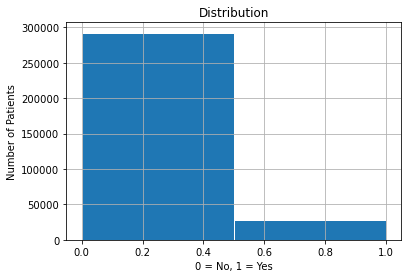

In [7]:
data['HeartDisease'].hist(bins = 2, edgecolor='white')
plt.title('Distribution')
plt.xlabel('0 = No, 1 = Yes')
plt.ylabel('Number of Patients')
plt.show()

In [4]:
#Preparation of target data Y, rest data X
data_target = data['HeartDisease']
data = data.drop(['HeartDisease'], axis=1)
#Generating Training, Test and Valdidation datasets in ratio 3:1:1
train, test, target_train, target_test = train_test_split(data, data_target, test_size=0.4, random_state=0)
#test, val, target_test, target_val = train_test_split(test, target_test, test_size=0.50)
print("Size Training dataset: ", len(train), "\nSize Test dataset: ", len(test)) #"\nSize Validation dataset", len(val))


Size Training dataset:  191877 
Size Test dataset:  127918


In [5]:
def training(algorithm, pred_train=False):
    algorithm.fit(train, target_train)
    prediction = algorithm.predict(test)
    prediction_proba = algorithm.predict_proba(test)
    if pred_train == False:
        return prediction, prediction_proba
    else:   
        prediction_train = algorithm.predict(train)
        prediction_proba_train = algorithm.predict_proba(train)
        return prediction, prediction_proba, prediction_train, prediction_proba_train


In [6]:
def comp_acc(prediction, truevalue):
    acc = accuracy_score(truevalue, prediction)
    return acc 

def comp_auc( prediction_proba, truevalue):
    auc = roc_auc_score(truevalue, prediction_proba[:, 1])
    return auc

def comp_roc( prediction_proba, truevalue):    
    fpr, tpr, thresholds = roc_curve(truevalue, prediction_proba[:, 1])
    #prec = precision_score(target_test, prediction)
    #rec = recall_score(target_test, prediction)
    #f1 = f1_score(target_test, prediction)
    return fpr, tpr, thresholds

In [14]:
def cross_val(algorithm, cv=5):
    scoring = {'acc': 'accuracy',
               'auc': 'roc_auc',
               'recall': 'recall'}

    results = cross_validate(algorithm, train, target_train, cv=cv, scoring=scoring, return_train_score=True)

    auc = results['test_auc']
    recall = results['test_recall']
    acc = results['test_acc']

    print(f'Area under RoC curve: {auc.mean():0.04f} ± {auc.std():0.04f}')
    print(f'Accuracy:             {acc.mean():0.04f} ± {acc.std():0.04f}')
    print(f'Recall:               {recall.mean():0.04f} ± {recall.std():0.04f}')

In [8]:
def check_maxdepth(criterion='entropy', max_value=20, plot_figure=False):
    training_acc =[]
    training_auc =[]
    test_acc =[]
    test_auc =[]
    roc=[]
    test_rec=[]
    training_rec=[]
    for i in range(1, max_value):
        algo = DecisionTreeClassifier(max_depth=i, criterion=criterion)
        prediction, prediction_proba, prediction_train, prediction_proba_train = training(algo, True)
        training_acc.append(comp_acc(prediction_train, target_train))
        training_auc.append(comp_auc(prediction_proba_train, target_train))
        test_acc.append(comp_acc(prediction, target_test))
        test_auc.append(comp_auc(prediction_proba, target_test))
        test_rec.append(recall_score(target_test, prediction))
        training_rec.append(recall_score(target_train, prediction_train))
        roc.append(comp_roc(prediction_proba, target_test))
    if plot_figure==True:
        plt.figure()
        plt.plot(range(1, max_value), training_acc, '--', label='Acc. Training Set')
        plt.plot(range(1, max_value), test_acc, color='darkred', label='Acc. Test Set')
        plt.xlabel=('Maximum Depth')
        plt.ylabel=('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.grid(alpha=0.4)
        path = 'figures/max_depth_' + str(max_value) + '_Criterion_' + criterion + str('_acc.pdf')
        plt.savefig(path)
        plt.show()
        plt.clf()
        plt.figure()
        plt.plot(range(1, max_value), training_rec,'--', color='cornflowerblue', label='Rec. Training Set')
        plt.plot(range(1, max_value), test_rec, color='tomato', label='Rec. Test Set')
        plt.xlabel=('Maximum Depth')
        plt.ylabel=('Recall')
        plt.legend()
        plt.tight_layout()
        plt.grid(alpha=0.4)
        path = 'figures/max_depth_' + str(max_value) + '_Criterion_' + criterion + str('_rec.pdf')
        plt.savefig(path)
        plt.show()
        plt.clf()
        plt.figure()
        plt.plot(roc[0][0], roc[0][1], '--', label='ROC with ' + str(1) + ' Maximum Depth')  
        for i in range(1, int(max_value/4)):
            name= 'ROC with ' + str(i*4) + ' Maximum Depth'
            plt.plot(roc[(i-1)*4][0], roc[(i-1)*4][1], '--', label=name)  
        plt.legend()
        plt.xlabel=('False Postive Rate')
        plt.ylabel=('False Negative Rate')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        path = 'figures/ROCmax_depth' + str(max_value) + '_Criterion' + criterion + str('.pdf')
        plt.savefig(path)  
        plt.show()

In [13]:
algo = DecisionTreeClassifier(max_depth=12, criterion='entropy')
print('DTC with Entropy Criterion')
cross_val(algo)

Area under RoC curve: 0.7794 ± 0.0040
Accuracy:             0.9104 ± 0.0007
Recall:               0.0994 ± 0.0087
[0.92431971 0.92391581 0.92377298 0.92465245 0.92467199]


In [14]:
algo = DecisionTreeClassifier(max_depth=12, criterion='gini')
print('DTC with Gini Criterion')
cross_val(algo)

DTC with Gini Criterion
Area under RoC curve: 0.7721 ± 0.0042
Accuracy:             0.9088 ± 0.0006
Recall:               0.1054 ± 0.0044
[0.92848907 0.9274793  0.9282094  0.92740811 0.92797488]


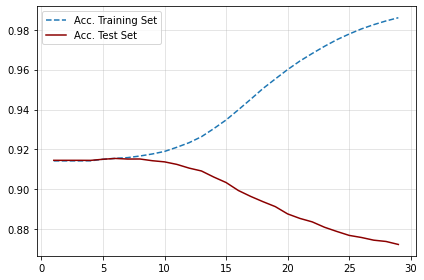

<Figure size 432x288 with 0 Axes>

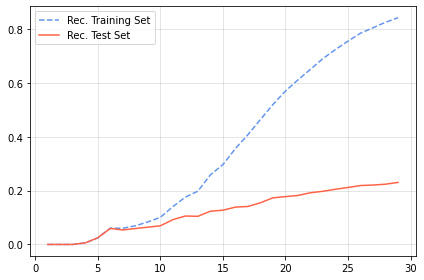

<Figure size 432x288 with 0 Axes>

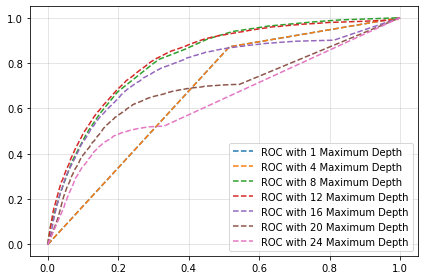

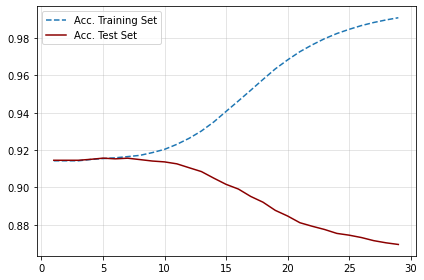

<Figure size 432x288 with 0 Axes>

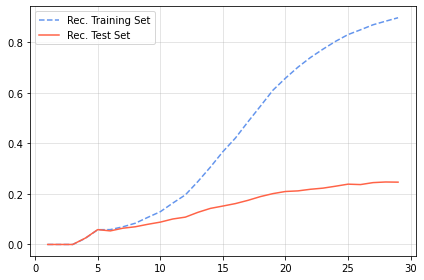

<Figure size 432x288 with 0 Axes>

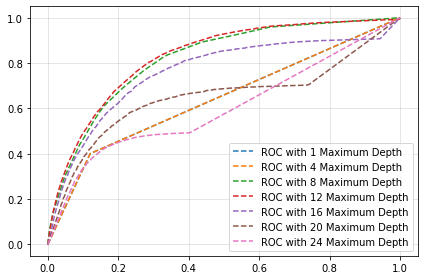

In [20]:
print('Checking max depth DTC with Entropy')
check_maxdepth('entropy', 30, True)
print('Checking max depth DTC with Gini')
check_maxdepth('gini', 30, True)

In [27]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=100
)
gbc = GradientBoostingClassifier(
    n_estimators=300,
)
hgb = HistGradientBoostingClassifier(max_iter=100, early_stopping=True)
cbc = CatBoostClassifier(n_estimators=100, verbose=0)

In [24]:
print('Cross Validation of AdaBoostClassifier')
cross_val(ada)

Cross Validation of AdaBoostClassifier
Area under RoC curve: 0.8383 ± 0.0027
Accuracy:             0.9147 ± 0.0013
Recall:               0.1028 ± 0.0056
[0.9152644  0.91641097 0.91542781 0.91604018 0.91561022]


In [28]:
print('Cross Validation of GradientBoostingClassifier')
cross_val(gbc)

Cross Validation of GradientBoostingClassifier
Area under RoC curve: 0.8442 ± 0.0018
Accuracy:             0.9159 ± 0.0006
Recall:               0.0936 ± 0.0032


In [29]:
print('Cross Validation of HistGradientBoostingClassifier')
cross_val(hgb)

Cross Validation of HistGradientBoostingClassifier
Area under RoC curve: 0.8439 ± 0.0018
Accuracy:             0.9156 ± 0.0005
Recall:               0.0801 ± 0.0047


In [30]:
print('Cross Validation of CatBoostClassifier')
cross_val(cbc)

Cross Validation of CatBoostClassifier
Learning rate set to 0.5
0:	learn: 0.4203337	total: 65.1ms	remaining: 6.45s
1:	learn: 0.3221527	total: 81.4ms	remaining: 3.99s
2:	learn: 0.2762469	total: 101ms	remaining: 3.27s
3:	learn: 0.2520018	total: 116ms	remaining: 2.79s
4:	learn: 0.2399389	total: 134ms	remaining: 2.54s
5:	learn: 0.2329928	total: 151ms	remaining: 2.36s
6:	learn: 0.2295039	total: 165ms	remaining: 2.19s
7:	learn: 0.2277634	total: 177ms	remaining: 2.04s
8:	learn: 0.2263319	total: 189ms	remaining: 1.91s
9:	learn: 0.2257524	total: 201ms	remaining: 1.81s
10:	learn: 0.2249897	total: 214ms	remaining: 1.73s
11:	learn: 0.2245089	total: 229ms	remaining: 1.68s
12:	learn: 0.2241555	total: 248ms	remaining: 1.66s
13:	learn: 0.2239444	total: 263ms	remaining: 1.62s
14:	learn: 0.2237701	total: 277ms	remaining: 1.57s
15:	learn: 0.2235947	total: 301ms	remaining: 1.58s
16:	learn: 0.2233795	total: 314ms	remaining: 1.53s
17:	learn: 0.2232374	total: 331ms	remaining: 1.51s
18:	learn: 0.2230002	total

61:	learn: 0.2180870	total: 2.9s	remaining: 1.78s
62:	learn: 0.2180249	total: 2.99s	remaining: 1.76s
63:	learn: 0.2179381	total: 3.07s	remaining: 1.73s
64:	learn: 0.2178422	total: 3.15s	remaining: 1.69s
65:	learn: 0.2177592	total: 3.23s	remaining: 1.66s
66:	learn: 0.2176877	total: 3.33s	remaining: 1.64s
67:	learn: 0.2176303	total: 3.43s	remaining: 1.61s
68:	learn: 0.2175193	total: 3.51s	remaining: 1.58s
69:	learn: 0.2173918	total: 3.6s	remaining: 1.54s
70:	learn: 0.2172573	total: 3.68s	remaining: 1.5s
71:	learn: 0.2171972	total: 3.76s	remaining: 1.46s
72:	learn: 0.2171355	total: 3.84s	remaining: 1.42s
73:	learn: 0.2170266	total: 3.94s	remaining: 1.38s
74:	learn: 0.2169158	total: 4.03s	remaining: 1.34s
75:	learn: 0.2167947	total: 4.11s	remaining: 1.3s
76:	learn: 0.2166852	total: 4.2s	remaining: 1.25s
77:	learn: 0.2166091	total: 4.29s	remaining: 1.21s
78:	learn: 0.2165704	total: 4.37s	remaining: 1.16s
79:	learn: 0.2164842	total: 4.45s	remaining: 1.11s
80:	learn: 0.2163400	total: 4.54s	re

30:	learn: 0.2213884	total: 388ms	remaining: 865ms
31:	learn: 0.2212717	total: 400ms	remaining: 850ms
32:	learn: 0.2211707	total: 411ms	remaining: 835ms
33:	learn: 0.2210662	total: 424ms	remaining: 823ms
34:	learn: 0.2209701	total: 436ms	remaining: 810ms
35:	learn: 0.2208039	total: 450ms	remaining: 799ms
36:	learn: 0.2207033	total: 462ms	remaining: 786ms
37:	learn: 0.2206234	total: 474ms	remaining: 774ms
38:	learn: 0.2204594	total: 488ms	remaining: 764ms
39:	learn: 0.2203589	total: 504ms	remaining: 757ms
40:	learn: 0.2202873	total: 522ms	remaining: 751ms
41:	learn: 0.2202035	total: 540ms	remaining: 745ms
42:	learn: 0.2201344	total: 552ms	remaining: 732ms
43:	learn: 0.2199921	total: 565ms	remaining: 719ms
44:	learn: 0.2199309	total: 576ms	remaining: 703ms
45:	learn: 0.2198282	total: 591ms	remaining: 694ms
46:	learn: 0.2196753	total: 607ms	remaining: 685ms
47:	learn: 0.2194967	total: 623ms	remaining: 675ms
48:	learn: 0.2194168	total: 637ms	remaining: 663ms
49:	learn: 0.2193722	total: 648

Area under RoC curve: 0.8416 ± 0.0015
Accuracy:             0.9148 ± 0.0005
Recall:               0.0929 ± 0.0035


In [31]:
xg_clf = xgb.XGBClassifier(verbose=0)
print('Cross Validation of CatBoostClassifier')
cross_val(cbc)

Cross Validation of CatBoostClassifier
Learning rate set to 0.5
0:	learn: 0.4203337	total: 13.8ms	remaining: 1.36s
1:	learn: 0.3221527	total: 27.8ms	remaining: 1.36s
2:	learn: 0.2762469	total: 42.9ms	remaining: 1.39s
3:	learn: 0.2520018	total: 60.9ms	remaining: 1.46s
4:	learn: 0.2399389	total: 80.2ms	remaining: 1.52s
5:	learn: 0.2329928	total: 96ms	remaining: 1.5s
6:	learn: 0.2295039	total: 116ms	remaining: 1.54s
7:	learn: 0.2277634	total: 134ms	remaining: 1.54s
8:	learn: 0.2263319	total: 149ms	remaining: 1.51s
9:	learn: 0.2257524	total: 168ms	remaining: 1.51s
10:	learn: 0.2249897	total: 184ms	remaining: 1.49s
11:	learn: 0.2245089	total: 198ms	remaining: 1.45s
12:	learn: 0.2241555	total: 211ms	remaining: 1.41s
13:	learn: 0.2239444	total: 228ms	remaining: 1.4s
14:	learn: 0.2237701	total: 246ms	remaining: 1.39s
15:	learn: 0.2235947	total: 260ms	remaining: 1.36s
16:	learn: 0.2233795	total: 274ms	remaining: 1.34s
17:	learn: 0.2232374	total: 293ms	remaining: 1.33s
18:	learn: 0.2230002	total

72:	learn: 0.2171355	total: 1.01s	remaining: 373ms
73:	learn: 0.2170266	total: 1.03s	remaining: 361ms
74:	learn: 0.2169158	total: 1.05s	remaining: 349ms
75:	learn: 0.2167947	total: 1.06s	remaining: 335ms
76:	learn: 0.2166852	total: 1.08s	remaining: 322ms
77:	learn: 0.2166091	total: 1.09s	remaining: 308ms
78:	learn: 0.2165704	total: 1.1s	remaining: 294ms
79:	learn: 0.2164842	total: 1.12s	remaining: 279ms
80:	learn: 0.2163400	total: 1.13s	remaining: 265ms
81:	learn: 0.2162862	total: 1.15s	remaining: 251ms
82:	learn: 0.2162219	total: 1.16s	remaining: 237ms
83:	learn: 0.2161229	total: 1.17s	remaining: 223ms
84:	learn: 0.2160590	total: 1.18s	remaining: 209ms
85:	learn: 0.2160075	total: 1.2s	remaining: 195ms
86:	learn: 0.2159309	total: 1.21s	remaining: 181ms
87:	learn: 0.2158741	total: 1.22s	remaining: 167ms
88:	learn: 0.2158169	total: 1.23s	remaining: 153ms
89:	learn: 0.2157670	total: 1.25s	remaining: 138ms
90:	learn: 0.2156990	total: 1.26s	remaining: 124ms
91:	learn: 0.2156270	total: 1.27s

39:	learn: 0.2203589	total: 598ms	remaining: 897ms
40:	learn: 0.2202873	total: 613ms	remaining: 883ms
41:	learn: 0.2202035	total: 629ms	remaining: 869ms
42:	learn: 0.2201344	total: 643ms	remaining: 853ms
43:	learn: 0.2199921	total: 660ms	remaining: 840ms
44:	learn: 0.2199309	total: 677ms	remaining: 828ms
45:	learn: 0.2198282	total: 701ms	remaining: 823ms
46:	learn: 0.2196753	total: 720ms	remaining: 811ms
47:	learn: 0.2194967	total: 735ms	remaining: 796ms
48:	learn: 0.2194168	total: 753ms	remaining: 784ms
49:	learn: 0.2193722	total: 768ms	remaining: 768ms
50:	learn: 0.2193288	total: 784ms	remaining: 754ms
51:	learn: 0.2192687	total: 805ms	remaining: 744ms
52:	learn: 0.2192170	total: 827ms	remaining: 734ms
53:	learn: 0.2190663	total: 851ms	remaining: 725ms
54:	learn: 0.2189665	total: 871ms	remaining: 713ms
55:	learn: 0.2187982	total: 891ms	remaining: 700ms
56:	learn: 0.2187541	total: 907ms	remaining: 684ms
57:	learn: 0.2185989	total: 926ms	remaining: 670ms
58:	learn: 0.2184782	total: 943

Area under RoC curve: 0.8416 ± 0.0015
Accuracy:             0.9148 ± 0.0005
Recall:               0.0929 ± 0.0035


In [57]:
def boosting(algo, name='ada'):
    algo.fit(train, target_train)
    y_prediction = algo.predict(test)#
    y_prediction_train = algo.predict(train)
    y_prediction_proba = algo.predict_proba(test)
    #scores = np.array(list(algo.staged_score(test, target_test)))
    acc_test = [accuracy_score(y_prediction, target_test) for y_prediction in algo.staged_predict(test)]
    acc_train = [accuracy_score(y_prediction_train, target_train) for y_prediction_train in algo.staged_predict(train)]
    rec_test = [recall_score(y_prediction, target_test, zero_division=1) for y_prediction in algo.staged_predict(test)]
    rec_train = [recall_score(y_prediction_train, target_train, zero_division=1) for y_prediction_train in algo.staged_predict(train)]
    plt.figure()
    plt.plot(range(len(acc_test)), acc_test, color='blue', linestyle='dotted', label='Acc. Test Set')
    plt.plot(range(len(acc_train)), acc_train, color='cyan', linestyle='dotted', label='Acc. Train Set')
    plt.plot(range(len(rec_test)), rec_test, color='red', linestyle='dotted',label='Rec. Test Set')
    plt.plot(range(len(rec_train)), rec_train, color='blue', linestyle= 'dotted', label='Rec. Train Set')
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.4)
    plt.ylabel=('Accuracy')
    plt.xlabel=('Iteration')
    PATH='figures/boosting_number_of_estimators_' + name+ '.pdf'
    plt.savefig(PATH)
    plt.show()

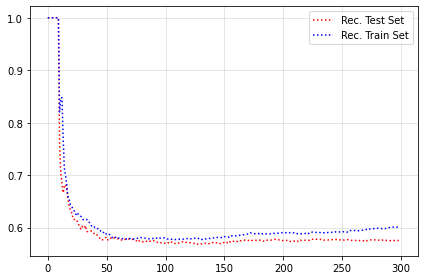

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


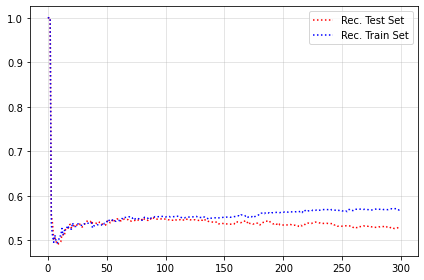

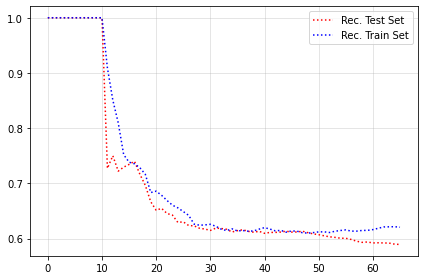

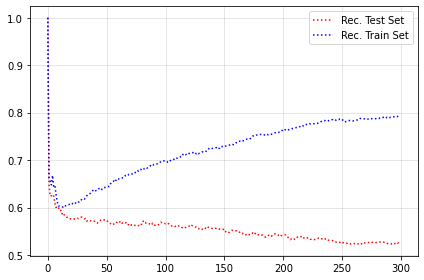

In [46]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=300
)
gbc = GradientBoostingClassifier(
    n_estimators=300,
)
hgb = HistGradientBoostingClassifier(max_iter=300, early_stopping=True)
cbc = CatBoostClassifier(n_estimators=300, verbose=0)

boosting(gbc, 'gbc')
boosting(ada, 'ada')
boosting(hgb, 'hgb')
boosting(cbc, 'cbc')

In [42]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=137)
print('Cross Validation Random Forest Classifier')
cross_val(rf)

Cross Validation Random Forest Classifier
Area under RoC curve: 0.8344 ± 0.0015
Accuracy:             0.9153 ± 0.0005
Recall:               0.0612 ± 0.0051


In [1]:
bg = BaggingClassifier(n_estimators=300, random_state=137)
print('Cross Validation Bagging Classifier ')
cross_val(bg)

NameError: name 'BaggingClassifier' is not defined

In [17]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

In [31]:
over_sampler = [RandomOverSampler(), SMOTE(), ADASYN()]
algos = [DecisionTreeClassifier(max_depth=12, criterion='entropy'),
         HistGradientBoostingClassifier(max_iter=300, early_stopping=True), 
         CatBoostClassifier(n_estimators=300, verbose=0)]

In [32]:
for sampler in over_sampler:
    for algorithm in algos:
        model = make_pipeline(sampler, algo)
        print(model)
        cross_val(model)

Pipeline(steps=[('randomoversampler', RandomOverSampler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbae81eae80>)])
Area under RoC curve: 0.8261 ± 0.0014
Accuracy:             0.7601 ± 0.0017
Recall:               0.7362 ± 0.0081
Pipeline(steps=[('randomoversampler', RandomOverSampler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbae81eae80>)])


KeyboardInterrupt: 

In [70]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks
model = make_pipeline(RandomUnderSampler(), DecisionTreeClassifier(max_depth=6))

In [42]:
cross_val(model)

Area under RoC curve: 0.8421 ± 0.0019
Accuracy:             0.7314 ± 0.0008
Recall:               0.8087 ± 0.0035


In [43]:
from imblearn.ensemble import RUSBoostClassifier

In [80]:
rus = RUSBoostClassifier(n_estimators=100)

In [81]:
a, b = training(rus)

In [72]:
model.fit(train, target_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6))])

In [79]:
pd.Series(rus.feature_importances_, index=data.columns)

BMI                 0.326667
Smoking             0.016667
AlcoholDrinking     0.003333
Stroke              0.046667
PhysicalHealth      0.063333
MentalHealth        0.043333
DiffWalking         0.026667
Sex                 0.010000
AgeCategory         0.116667
Race                0.023333
Diabetic            0.010000
PhysicalActivity    0.000000
GenHealth           0.063333
SleepTime           0.146667
Asthma              0.020000
KidneyDisease       0.056667
SkinCancer          0.026667
dtype: float64

In [78]:
res = "\n".join("{} {}".format(x, y) for x, y in zip(data.columns, model.steps[1][1].feature_importances_))
print(res)

BMI 0.005530833612307523
Smoking 0.0032419683054256535
AlcoholDrinking 0.0005497328766124294
Stroke 0.05521141121267712
PhysicalHealth 0.0015283850816704568
MentalHealth 0.000704138662971497
DiffWalking 0.0038414795380513314
Sex 0.060364797294162394
AgeCategory 0.5586850200057463
Race 0.0019783487696937024
Diabetic 0.01305641406623163
PhysicalActivity 0.001064839875788024
GenHealth 0.290741285921143
SleepTime 0.0019883982985608763
Asthma 0.001512946478957966
KidneyDisease 0.0
SkinCancer 0.0


(array([90412.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 37506.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

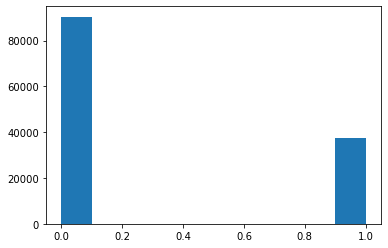

In [85]:
plt.hist(a)

(array([116990.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  10928.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

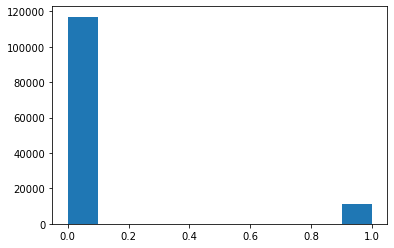

In [86]:
plt.hist(target_test)